# Load and process

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, classification_report

#### Read file

In [2]:
df = pd.read_json('data/beauty_final.json', lines=True)
df = df[df.product_category == 'Beauty']
df = df[df.total_votes > 5]
df.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase
0,14459848,25,Beauty,B000052ZBD,"While vacationing in Alaska, we stayed in a fa...",2005-09-14,RE1WMA50104QQ,5,28,N


#### Add useful columns

In [3]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]
df.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
0,14459848,25,Beauty,B000052ZBD,"While vacationing in Alaska, we stayed in a fa...",2005-09-14,RE1WMA50104QQ,5,28,N,0.89,True,406


#### Stats

In [4]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
35571

helpful count
24722

not helpful count
10849

average helpfulness
0.8300610047510162

average length of helpful review
692.283512660788

average length of not helpful review
623.3086920453499


# Analyse factors vs helpfulness

#### Review length

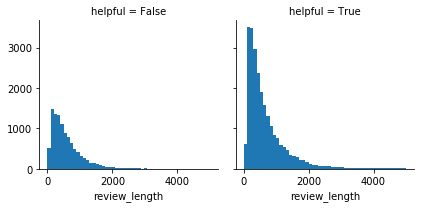

In [5]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=50)

#### Star rating

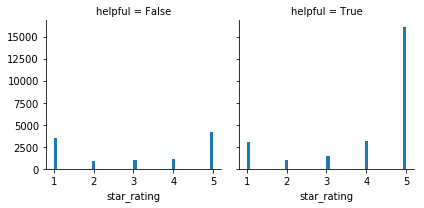

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

#### Verified purchase

In [7]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {0}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {0}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.8370278924749026
avg helpfulness of unverified purchases: 0.8160919151812005


# Predicting using Naive Bayes

In [8]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and len(word) > 3]

In [9]:
X = df['review_body']
Y = df['helpful']

In [10]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [11]:
X = bow_transformer.transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [36]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 865 2356]
 [ 804 6647]]


              precision    recall  f1-score   support

       False       0.52      0.27      0.35      3221
        True       0.74      0.89      0.81      7451

   micro avg       0.70      0.70      0.70     10672
   macro avg       0.63      0.58      0.58     10672
weighted avg       0.67      0.70      0.67     10672



#### ComplementNB 

In [15]:
cnb = ComplementNB()
cnb.fit(X_train, Y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [16]:
preds = cnb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[1172 2049]
 [1232 6219]]


              precision    recall  f1-score   support

       False       0.49      0.36      0.42      3221
        True       0.75      0.83      0.79      7451

   micro avg       0.69      0.69      0.69     10672
   macro avg       0.62      0.60      0.60     10672
weighted avg       0.67      0.69      0.68     10672



#### Manual examination

In [17]:
df[df.helpfulness > 0.1].sort_values('helpfulness').head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
34450,12018178,2,Beauty,B002C7487U,"it is a product that is too soon to review,as ...",2012-03-27,R2GGSCW9AVUEV9,3,18,Y,0.11,False,232


In [18]:
mid_review = df['review_body'][2808]
mid_review_transformed = bow_transformer.transform([mid_review])
print("predicted helpful: {0}, actual helpfulness: {1}".format(nb.predict(mid_review_transformed)[0],df['helpfulness'][2808]))

predicted helpful: False, actual helpfulness: 0.11


#### Popular products

In [19]:
df.product_id.value_counts(ascending=False).head(6)

B00LFT0CEO    80
B002W2HIYA    67
B00IAMTLS2    58
B00064LO3C    55
B002VBE6N8    54
B00005JHWB    53
Name: product_id, dtype: int64

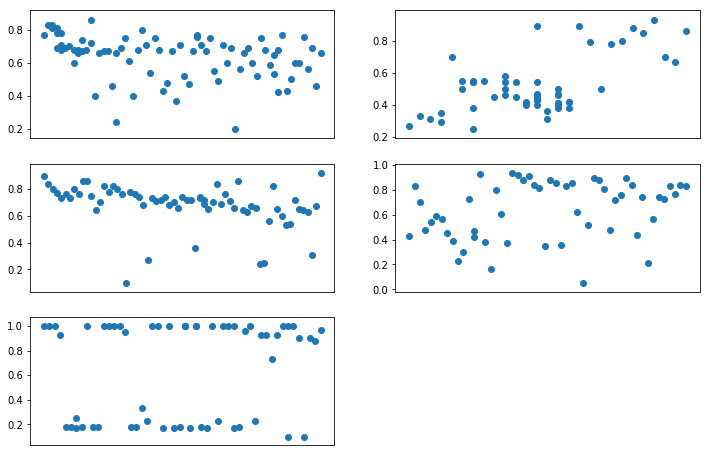

In [20]:
df_1 = df[df.product_id == 'B00LFT0CEO']
df_2 = df[df.product_id == 'B002W2HIYA']
df_3 = df[df.product_id == 'B00IAMTLS2']
df_4 = df[df.product_id == 'B00064LO3C']
df_5 = df[df.product_id == 'B002VBE6N8']
df_6 = df[df.product_id == 'B00005JHWB']

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (2, 0))
ax4 = plt.subplot2grid(gridsize, (0, 1))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 1))

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_xticks([])

sctr = ax1.scatter(x = df_1.review_date, y = df_1.helpfulness)
sctr = ax2.scatter(x = df_2.review_date, y = df_2.helpfulness)
sctr = ax3.scatter(x = df_3.review_date, y = df_3.helpfulness)
sctr = ax4.scatter(x = df_4.review_date, y = df_4.helpfulness)
sctr = ax5.scatter(x = df_5.review_date, y = df_5.helpfulness)
sctr = ax6.scatter(x = df_6.review_date, y = df_6.helpfulness)

# Using classifier on auto dataset

In [39]:
df_a = pd.read_json('data/auto_final.json', lines=True)

In [40]:
df_a = df_a.dropna()

df_a['helpfulness'] = (df_a.helpful_votes / df_a.total_votes).round(2)
df_a['helpful'] = df_a.helpfulness > 0.8

df_a['review_length'] = df_a['review_body'].apply(len)
df_a = df_a[df_a.review_length <= 5000]
df_a.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
0,47145486,17,Automotive,B0000AX5XB,In the costume building world we spend a ton o...,2013-06-09,R1XEJVWH5WSN5W,4,17,N,1.0,True,661


In [41]:
X_a = df_a['review_body']
Y_a = df_a['helpful']

In [43]:
X_a = bow_transformer.transform(X_a)

In [44]:
X_a_train, X_a_test, Y_a_train, Y_a_test = train_test_split(X_a, Y_a, test_size=0.3, random_state=101)

In [34]:
# nb = MultinomialNB()
# nb.fit(X_electronics_train, Y_electronics_train)

In [45]:
preds = nb.predict(X_a_test)

print(confusion_matrix(Y_a_test, preds))
print('\n')
print(classification_report(Y_a_test, preds))

[[ 177  956]
 [ 230 3018]]


              precision    recall  f1-score   support

       False       0.43      0.16      0.23      1133
        True       0.76      0.93      0.84      3248

   micro avg       0.73      0.73      0.73      4381
   macro avg       0.60      0.54      0.53      4381
weighted avg       0.68      0.73      0.68      4381



# Using classifier on extreme reviews

In [99]:
df_ = df[df.total_votes > 30]
df_e1 = df_[df_.helpfulness < 0.2]
df_e2 = df_[df_.helpfulness > 0.99]

df_e = pd.concat([df_e1,df_e2])

In [100]:
df_e1.customer_id.count()

98

In [101]:
df_e2.customer_id.count()

503

In [102]:
X = df_e['review_body']
Y = df_e['helpful']

In [103]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [104]:
X = bow_transformer.transform(X)

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [106]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [107]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[  3  24]
 [  6 148]]


              precision    recall  f1-score   support

       False       0.33      0.11      0.17        27
        True       0.86      0.96      0.91       154

   micro avg       0.83      0.83      0.83       181
   macro avg       0.60      0.54      0.54       181
weighted avg       0.78      0.83      0.80       181

